In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:

def fsin(f):
    rand = np.random.random(size=5)
    x = np.linspace(-1, 1, 32*4)
    y = np.sin((x+rand[0]) * f) * rand[1] + rand[2]
    return y
    

In [3]:
class sorq(Dataset):
    def __init__(
            self,
            length=1000,
            device="cuda:0"
    ):
        self.length = length
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        rands = np.random.rand(2)
        output = fsin(index%19) * rands[0] + rands[1]*3
        return (torch.tensor(output).view(-1,1).to(self.device).to(torch.float),
                torch.full((len(output),),index%19).view(-1,1).to(self.device).to(torch.float))

    def __str__(self) -> str:
        return f"{self.length}"

dataset = sorq(length=1_000_000)

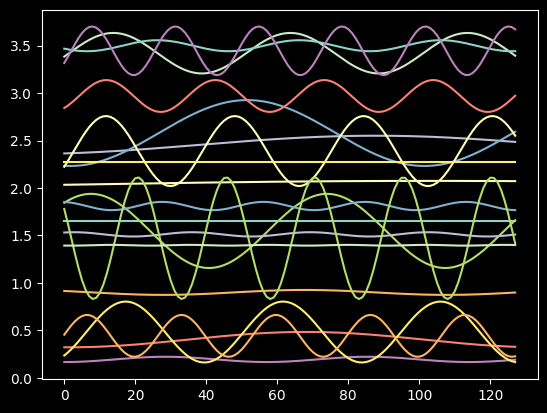

In [10]:
for i in range(0,20):
    # print(dataset[i][1][0].item())
    plt.plot(dataset[i][0].detach().cpu())
plt.show()

In [5]:
# c,d = next(iter(dataloader))
# for i,j in zip(c,d):
#     print(j.T,i.shape,j.shape)
#     plt.plot(i.detach().cpu())
#     plt.show()

In [6]:
class LSTMDiscriminatorRF(nn.Module):
    """An LSTM based discriminator. It expects a sequence as input and outputs a probability for each element. 
    Args:
        in_dim: Input noise dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Inputs: sequence of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, 1)
    """

    def __init__(self, in_dim,out_dim = 19, n_layers=1, hidden_dim=256):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.linear_recurrent = nn.Sequential(nn.Linear(hidden_dim, out_dim), nn.Sigmoid())

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to("cuda:0")
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to("cuda:0")

        recurrent_features, (h_out,c_out) = self.lstm(input, (h_0, c_0))
        outputs = self.linear_recurrent(recurrent_features.contiguous().view(batch_size*seq_len, self.hidden_dim))
        outputs = outputs.view(batch_size, seq_len, self.out_dim)
        return outputs

In [7]:
batch_size = 16
input_dimenstions = 1
layers = 4
hidden_size = 1024
dataloader = DataLoader(dataset,batch_size=16,shuffle = True)

disc1 = LSTMDiscriminatorRF(input_dimenstions,n_layers=layers,hidden_dim=hidden_size).to("cuda:0")
optimizer1 = optim.Adam(disc1.parameters(), lr=1e-4)
criterion = nn.BCELoss().to(dataset.device)


In [8]:
print("epoch |  bnum  | errD1  | errD2  | errD3  | errD4")
for epoch in range(30):
    for i, (data,label) in enumerate(dataloader, 0):
        # print(data.device,label.device)
        disc1.zero_grad()
        output = disc1(data)
        print(output[:,-1:].view(16,19),label[:,-1:].view(16,1))
        errD1 = criterion(output[:,-1:].view(16,19),label[:,-1:].view(16,1))
        errD1.backward()
        optimizer1.step()

        print(f"{epoch:5} | {i:6} | {errD1.item():6.3}",end = "\r",flush=True)
        if i%100 == 0:
            print()
    print("\nepoch finished: ",epoch)

epoch |  bnum  | errD1  | errD2  | errD3  | errD4
tensor([[0.4979, 0.4927, 0.4974, 0.4986, 0.5019, 0.4997, 0.5045, 0.5001, 0.5033,
         0.4968, 0.4993, 0.5091, 0.4993, 0.4968, 0.4979, 0.5018, 0.4981, 0.4956,
         0.5024],
        [0.4979, 0.4927, 0.4974, 0.4986, 0.5019, 0.4997, 0.5045, 0.5002, 0.5033,
         0.4968, 0.4993, 0.5092, 0.4993, 0.4968, 0.4979, 0.5018, 0.4981, 0.4955,
         0.5024],
        [0.4979, 0.4927, 0.4974, 0.4986, 0.5019, 0.4997, 0.5045, 0.5001, 0.5032,
         0.4968, 0.4993, 0.5091, 0.4993, 0.4969, 0.4978, 0.5018, 0.4981, 0.4956,
         0.5024],
        [0.4979, 0.4927, 0.4974, 0.4986, 0.5019, 0.4997, 0.5045, 0.5001, 0.5033,
         0.4968, 0.4993, 0.5091, 0.4993, 0.4968, 0.4979, 0.5018, 0.4981, 0.4955,
         0.5024],
        [0.4979, 0.4927, 0.4974, 0.4986, 0.5019, 0.4997, 0.5045, 0.5001, 0.5033,
         0.4968, 0.4993, 0.5091, 0.4993, 0.4969, 0.4978, 0.5018, 0.4981, 0.4956,
         0.5024],
        [0.4979, 0.4927, 0.4974, 0.4987, 0.5020, 0

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
c,label = next(iter(DataLoader(dataset=dataset,batch_size=len(dataset),shuffle=True)))
output = disc1(c)
plabel = label[:,0,:]
output = output.view(-1,1)
print(plabel.shape, output.shape)
corrects = []
for i,j in zip(plabel,output):
    print(i.item(),round(j.item()))
    corrects.append(int(i.item() == j.item()))
